In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ROOT = Path.cwd().resolve()
while not (ROOT / 'data').exists() and ROOT.parent != ROOT:
    ROOT = ROOT.parent
DATA_RAW = ROOT / 'data' / 'raw'
WEIGHT_CSV = DATA_RAW / 'weight.csv'

if not WEIGHT_CSV.exists():
    alt = DATA_RAW / 'weights.csv'
    if alt.exists():
        WEIGHT_CSV = alt

print('Looking for:', WEIGHT_CSV)

try:
    df = pd.read_csv(WEIGHT_CSV)
except Exception as e:
    print('Initial read failed:', e)
    df = pd.read_csv(WEIGHT_CSV, encoding='latin-1')

print('Loaded shape:', df.shape)
df.head()

Looking for: C:\Users\chris\Documents\lab\mlife\data\raw\weight.csv
Loaded shape: (33763, 9)


,Participant ID,Participant name,Group,Date,Time,Weight,Bmi,Source,Fat
0,94,user user 94,mLife (control),06/13/2022,09:31:23 am,183.4,32.50,AriaAir,-
1,94,user user 94,mLife (control),06/14/2022,07:44:41 am,183.0,32.42,AriaAir,-
2,102,user user 102,mLife (control),06/15/2022,03:53:53 pm,159.0,25.68,AriaAir,-
3,103,user user 103,mLife (control),06/15/2022,05:00:13 pm,197.6,32.88,AriaAir,-
4,112,user user 112,mLife (control),06/15/2022,11:59:59 pm,187.9,35.54,API,-


In [ ]:
df.info()

for c in df.columns:
    print(c, '->', pd.Series(df[c].dropna().unique()[:5]).to_list())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33763 entries, 0 to 33762
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Participant ID    33763 non-null  int64  
 1   Participant name  33763 non-null  object 
 2   Group             33763 non-null  object 
 3   Date              33763 non-null  object 
 4   Time              33763 non-null  object 
 5   Weight            33763 non-null  float64
 6   Bmi               33763 non-null  float64
 7   Source            33763 non-null  object 
 8   Fat               33763 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.3+ MB
Participant ID -> [94, 102, 103, 112, 114]
Participant name -> ['user user 94', 'user user 102', 'user user 103', 'user user 112', 'user user 114']
Group -> ['mLife (control)', 'mLife+Points', 'mLife+Points2', 'mLife (control2)']
Date -> ['06/13/2022', '06/14/2022', '06/15/2022', '06/16/2022', '06/17/2022']
Time

In [ ]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]

Series([], dtype: int64)

In [ ]:
print('Total duplicates rows:', df.duplicated().sum())

potential_datetime = []
for c in df.columns:
    sample = df[c].dropna().astype(str).head(20).to_list()
    datetime_like = sum(1 for v in sample if any(ch.isdigit() for ch in v) and ('-' in v or '/' in v or ':' in v))
    if datetime_like>0:
        potential_datetime.append(c)
print('Potential datetime-like columns:', potential_datetime)

Total duplicates rows: 0
Potential datetime-like columns: ['Date', 'Time']


In [ ]:
numeric = df.select_dtypes(include=[np.number])
numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
Participant ID,33763.0,1139.536534,1007.264862,7.00,58.00,2005.0,2088.00,2175.00
Weight,33763.0,197.495910,41.812009,6.90,169.80,191.0,225.40,571.90
Bmi,33763.0,32.476950,5.851091,1.16,28.19,32.0,36.49,111.71


In [ ]:
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
coerced = {}
for c in obj_cols:
    coerced[c] = pd.to_numeric(df[c].astype(str).str.replace(',',''), errors='coerce').notna().sum()
coerced

{'Participant name': np.int64(0),
 'Group': np.int64(0),
 'Date': np.int64(0),
 'Time': np.int64(0),
 'Source': np.int64(0),
 'Fat': np.int64(4813)}

In [ ]:
import scipy.stats as stats
outliers = {}
for c in numeric.columns:
    col = numeric[c].dropna()
    if len(col)>0:
        z = np.abs(stats.zscore(col))
        outliers[c] = (z>3).sum(), len(col)
outliers

{'Participant ID': (np.int64(0), 33763),
 'Weight': (np.int64(191), 33763),
 'Bmi': (np.int64(12), 33763)}

Datetime parse/plot failed: agg function failed [how->mean,dtype->object]


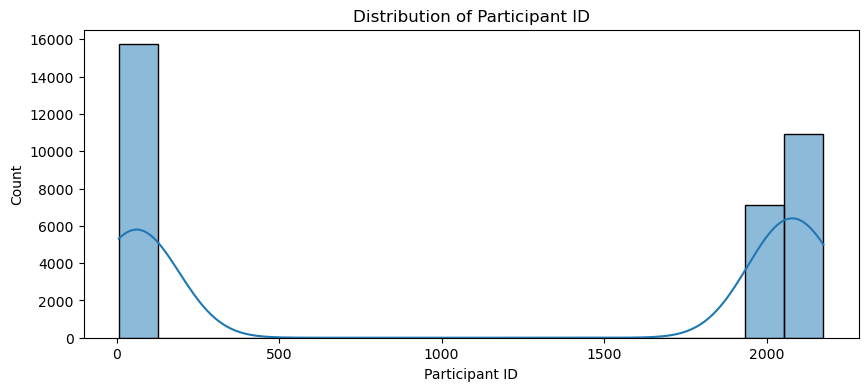

In [ ]:
plt.figure(figsize=(10,4))
if len(numeric.columns)>0:
    c = numeric.columns[0]
    sns.histplot(numeric[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')

dt_col = potential_datetime[0] if len(potential_datetime)>0 else None
if dt_col is not None:
    try:
        df['_parsed_dt'] = pd.to_datetime(df[dt_col], errors='coerce')
        if '_parsed_dt' in df.columns and df['_parsed_dt'].notna().sum()>0 and len(numeric.columns)>0:
            ts = df.set_index('_parsed_dt').resample('D').mean()
            plt.figure(figsize=(12,4))
            sns.lineplot(data=ts, x=ts.index, y=numeric.columns[0])
            plt.title('Daily mean '+numeric.columns[0])
    except Exception as e:
        print('Datetime parse/plot failed:', e)

In [ ]:
if '_parsed_dt' not in df.columns:
    df['_parsed_dt'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

total_rows = len(df)
unique_participants = df['Participant ID'].nunique()
participants_by_group = df.groupby('Group')['Participant ID'].nunique().sort_values(ascending=False)

entries_per_participant = df.groupby('Participant ID').size().rename('n_entries')
entries_summary = entries_per_participant.describe()

span = df.groupby('Participant ID')['_parsed_dt'].agg(['min','max'])
span['span_days'] = (span['max'] - span['min']).dt.days
span_summary = span['span_days'].describe()

thresholds = [1,5,10,20,50]
threshold_counts = {t: (entries_per_participant>=t).sum() for t in thresholds}

participant_summary = pd.concat([entries_per_participant, span['span_days']], axis=1).fillna(0)
participant_summary = participant_summary.rename(columns={0: 'n_entries', 'span_days':'span_days'})

print('Total rows:', total_rows)
print('Unique participants:', unique_participants)
print('\nParticipants by Group:')
print(participants_by_group)
print('\nEntries per participant (summary):')
print(entries_summary)
print('\nMeasurement span per participant (days, summary):')
print(span_summary)
print('\nParticipants meeting thresholds:')
for t,c in threshold_counts.items():
    print(f'  >={t}: {c}')

print('\nTop 10 participants by number of entries:')
print(entries_per_participant.sort_values(ascending=False).head(10))

out_csv = Path.cwd().resolve() / 'participant_summary_weights.csv'
participant_summary.to_csv(out_csv)
print('\nSaved participant-level summary to', out_csv)

Total rows: 33763
Unique participants: 243

Participants by Group:
Group
mLife (control2)    70
mLife+Points2       67
mLife+Points        54
mLife (control)     52
Name: Participant ID, dtype: int64

Entries per participant (summary):
count    243.000000
mean     138.942387
std      120.503681
min        1.000000
25%       29.000000
50%      103.000000
75%      237.000000
max      385.000000
Name: n_entries, dtype: float64

Measurement span per participant (days, summary):
count     243.000000
mean      294.650206
std       136.661905
min         0.000000
25%       205.500000
50%       364.000000
75%       378.000000
max      1049.000000
Name: span_days, dtype: float64

Participants meeting thresholds:
  >=1: 243
  >=5: 227
  >=10: 214
  >=20: 196
  >=50: 158

Top 10 participants by number of entries:
Participant ID
2004    385
54      375
2076    372
23      365
2128    363
94      362
2082    360
2127    359
27      359
19      358
Name: n_entries, dtype: int64

Saved participant-le

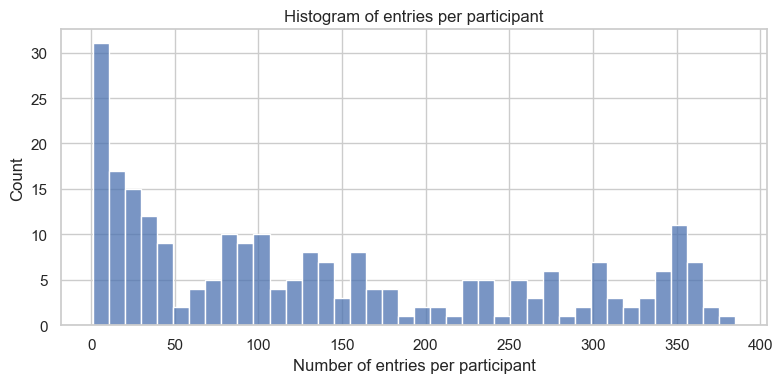

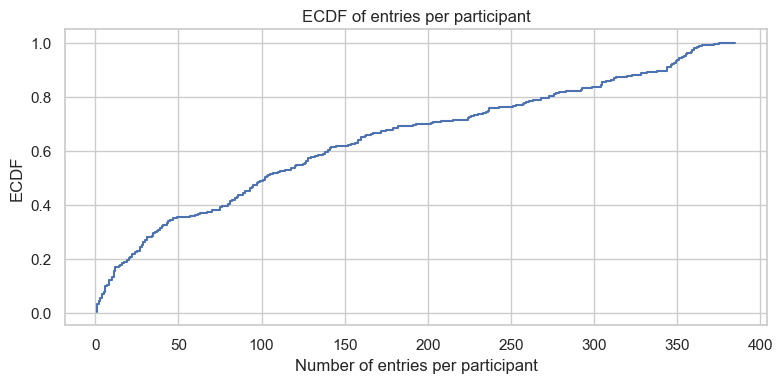

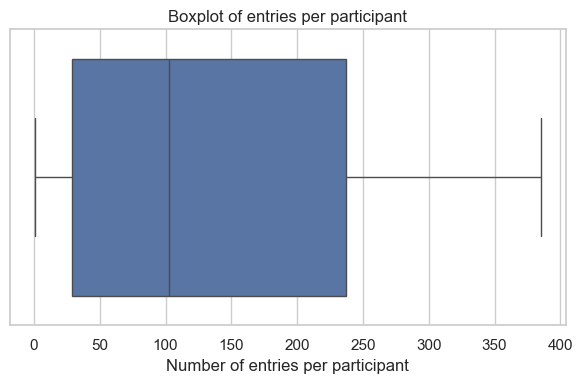

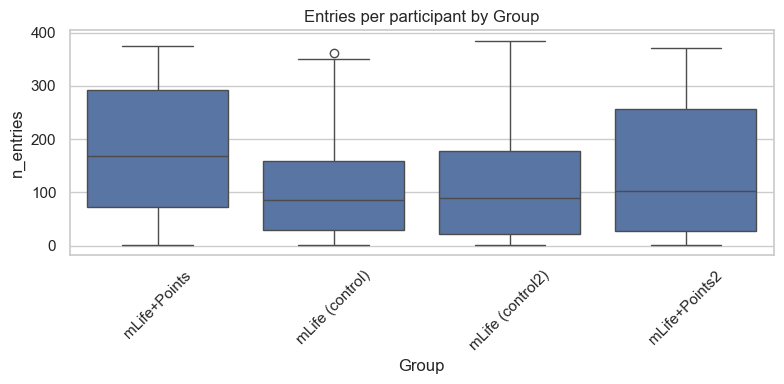

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(8,4))
sns.histplot(entries_per_participant, bins=40, kde=False)
plt.xlabel('Number of entries per participant')
plt.title('Histogram of entries per participant')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
vals = np.sort(entries_per_participant.values)
y = np.arange(1, len(vals)+1) / len(vals)
plt.step(vals, y)
plt.xlabel('Number of entries per participant')
plt.ylabel('ECDF')
plt.title('ECDF of entries per participant')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=entries_per_participant.values)
plt.xlabel('Number of entries per participant')
plt.title('Boxplot of entries per participant')
plt.tight_layout()
plt.show()

participant_group = df.groupby('Participant ID')['Group'].agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else x.iloc[0])
ps_df = entries_per_participant.reset_index()
ps_df.columns = ['Participant ID', 'n_entries']
pg = participant_group.reset_index()
pg.columns = ['Participant ID', 'Group']
ps_df = ps_df.merge(pg, on='Participant ID', how='left')

plt.figure(figsize=(8,4))
sns.boxplot(data=ps_df, x='Group', y='n_entries')
plt.xticks(rotation=45)
plt.title('Entries per participant by Group')
plt.tight_layout()
plt.show()

Parsed numeric Weight (lbs) missing: 0

Percentiles for Weight (lbs):
  0.1%: 125.20 lbs
  1.0%: 128.80 lbs
  5.0%: 135.20 lbs
  10.0%: 143.60 lbs
  25.0%: 169.80 lbs
  50.0%: 191.00 lbs
  75.0%: 225.40 lbs
  90.0%: 256.20 lbs
  95.0%: 271.20 lbs
  99.0%: 312.20 lbs
  99.9%: 328.32 lbs

Outlier rows? (<66 or >400): 6


,Participant ID,Date,Time,Weight_raw,Weight_lbs_num
9369,83,12/18/2022,11:59:59 pm,6.9,6.9
9689,83,12/27/2022,11:59:59 pm,6.9,6.9
13922,43,05/06/2023,11:59:59 pm,571.9,571.9
16356,2056,07/08/2023,11:59:59 pm,502.6,502.6
24750,2136,11/17/2023,11:59:59 pm,13.0,13.0
30238,2166,03/30/2024,11:59:59 pm,9.9,9.9



Consecutive large jumps (>22 lbs): 33


,Participant ID,_parsed_dt,Weight_lbs_num,prev_w_lbs,abs_change_lbs,days_diff
15943,23,2023-07-01,186.6,222.7,36.1,1.0
101,25,2022-06-18,86.6,146.0,59.4,3.0
129,25,2022-06-19,149.4,86.6,62.8,1.0
15347,29,2023-06-21,205.4,182.6,22.8,1.0
13922,43,2023-05-06,571.9,187.0,384.9,53.0
14012,43,2023-05-09,189.8,571.9,382.1,3.0
15214,43,2023-06-17,339.9,188.8,151.1,4.0
15282,43,2023-06-19,190.4,339.9,149.5,2.0
409,77,2022-06-27,145.0,172.8,27.8,12.0
531,77,2022-06-29,175.0,145.0,30.0,2.0


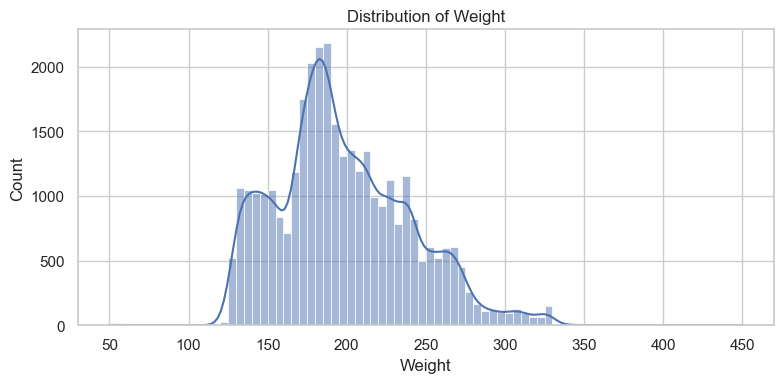

In [ ]:

df['Weight_lbs_num'] = pd.to_numeric(df['Weight_raw'].astype(str).str.replace(',','').str.replace('[^0-9.]','', regex=True), errors='coerce')
print('Parsed numeric Weight (lbs) missing:', df['Weight_lbs_num'].isna().sum())

pcts_lbs = df['Weight_lbs_num'].quantile([0.001,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_dict()
print('\nPercentiles for Weight (lbs):')
for k,v in pcts_lbs.items():
    print(f'  {k*100:.1f}%: {v:.2f} lbs')

implausible_mask_lbs = (df['Weight_lbs_num']<66) | (df['Weight_lbs_num']>400)
print('\nOutlier rows? (<66 or >400):', implausible_mask_lbs.sum())
if implausible_mask_lbs.sum()>0:
    display(df.loc[implausible_mask_lbs, ['Participant ID','Date','Time','Weight_raw','Weight_lbs_num']].head(10))

df_sorted = df.sort_values(['Participant ID','_parsed_dt'])
valid_lbs = df_sorted.dropna(subset=['Weight_lbs_num','_parsed_dt']).copy()
valid_lbs['prev_w_lbs'] = valid_lbs.groupby('Participant ID')['Weight_lbs_num'].shift(1)
valid_lbs['abs_change_lbs'] = (valid_lbs['Weight_lbs_num'] - valid_lbs['prev_w_lbs']).abs()
valid_lbs['days_diff'] = (valid_lbs['_parsed_dt'] - valid_lbs.groupby('Participant ID')['_parsed_dt'].shift(1)).dt.days
jump_mask_lbs = valid_lbs['abs_change_lbs']>22
print('\nConsecutive large jumps (>22 lbs):', jump_mask_lbs.sum())
if jump_mask_lbs.sum()>0:
    display(valid_lbs.loc[jump_mask_lbs, ['Participant ID','_parsed_dt','Weight_lbs_num','prev_w_lbs','abs_change_lbs','days_diff']].head(10))

plt.figure(figsize=(8,4))
sns.histplot(df['Weight_lbs_num'].dropna().clip(50,450), bins=80, kde=True)
plt.xlabel('Weight')
plt.title('Distribution of Weight')
plt.tight_layout()
plt.show()

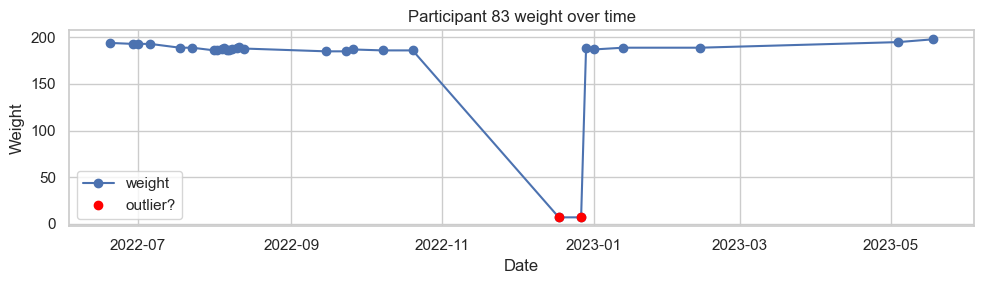

Rows for participant 83


,Participant ID,Date,Time,Weight_raw,Weight_lbs_num,Source,_parsed_dt
175,83,06/20/2022,11:59:59 pm,194.0,194.0,API,2022-06-20
535,83,06/29/2022,02:51:28 pm,193.0,193.0,API,2022-06-29
672,83,07/01/2022,10:48:45 pm,193.0,193.0,API,2022-07-01
1001,83,07/06/2022,12:00:00 am,193.0,193.0,API,2022-07-06
1817,83,07/18/2022,11:59:59 pm,188.9,188.9,API,2022-07-18
2150,83,07/23/2022,04:30:18 pm,188.9,188.9,API,2022-07-23
2734,83,08/01/2022,10:29:19 am,186.0,186.0,API,2022-08-01
2799,83,08/02/2022,12:00:00 am,186.0,186.0,API,2022-08-02
2924,83,08/04/2022,10:41:54 am,188.0,188.0,API,2022-08-04
2989,83,08/05/2022,07:49:24 am,188.5,188.5,API,2022-08-05



---



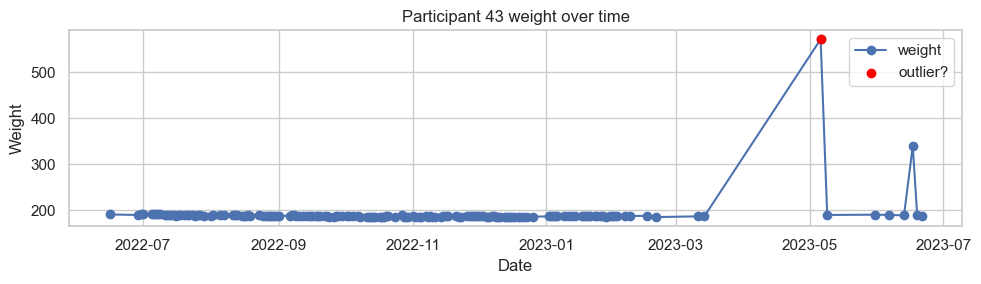

Rows for participant 43


,Participant ID,Date,Time,Weight_raw,Weight_lbs_num,Source,_parsed_dt
49,43,06/16/2022,07:09:44 am,190.9,190.9,API,2022-06-16
513,43,06/29/2022,07:44:28 am,189.8,189.8,AriaAir,2022-06-29
585,43,06/30/2022,08:41:22 am,191.2,191.2,AriaAir,2022-06-30
647,43,07/01/2022,06:41:16 am,191.6,191.6,AriaAir,2022-07-01
911,43,07/05/2022,12:00:00 am,191.0,191.0,API,2022-07-05
...,...,...,...,...,...,...,...
14830,43,06/06/2023,07:03:29 am,190.0,190.0,AriaAir,2023-06-06
15054,43,06/13/2023,07:34:31 am,188.8,188.8,AriaAir,2023-06-13
15214,43,06/17/2023,11:59:59 pm,339.9,339.9,API,2023-06-17
15282,43,06/19/2023,07:11:14 am,190.4,190.4,AriaAir,2023-06-19



---

Participant 256: no rows found


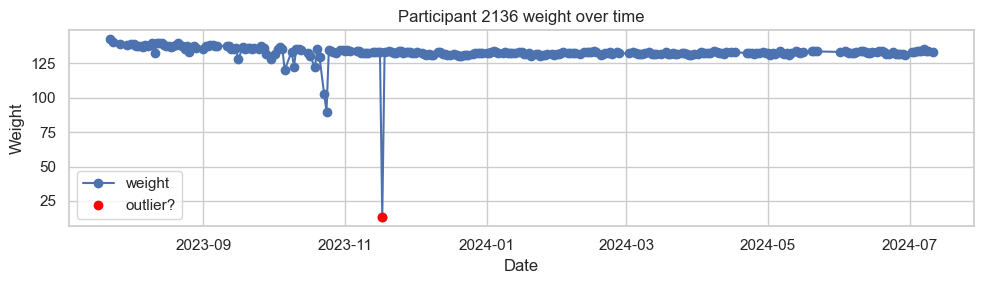

Rows for participant 2136


,Participant ID,Date,Time,Weight_raw,Weight_lbs_num,Source,_parsed_dt
17637,2136,07/23/2023,08:12:00 pm,142.6,142.6,API,2023-07-23
17712,2136,07/24/2023,11:59:59 pm,140.4,140.4,API,2023-07-24
17944,2136,07/27/2023,11:59:59 pm,139.5,139.5,API,2023-07-27
18153,2136,07/30/2023,07:49:35 am,138.8,138.8,API,2023-07-30
18314,2136,08/01/2023,11:59:59 pm,139.4,139.4,API,2023-08-01
...,...,...,...,...,...,...,...
33590,2136,07/06/2024,07:06:27 am,134.2,134.2,API,2024-07-06
33614,2136,07/07/2024,11:59:59 pm,135.8,135.8,API,2024-07-07
33641,2136,07/08/2024,11:59:59 pm,134.4,134.4,API,2024-07-08
33668,2136,07/09/2024,06:48:15 am,134.4,134.4,API,2024-07-09



---



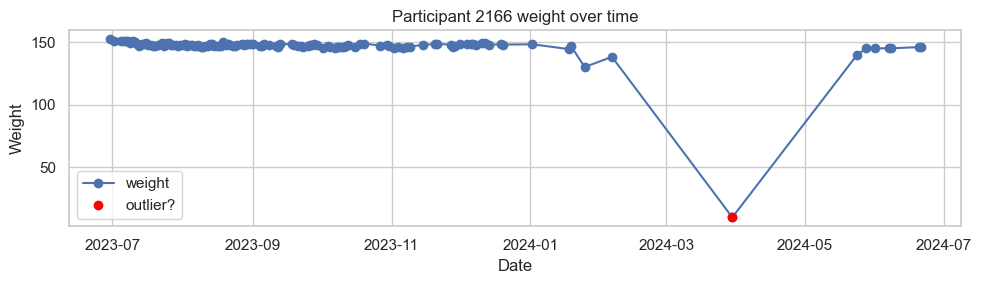

Rows for participant 2166


,Participant ID,Date,Time,Weight_raw,Weight_lbs_num,Source,_parsed_dt
15879,2166,06/30/2023,11:12:08 pm,152.2,152.2,AriaAir,2023-06-30
16002,2166,07/02/2023,09:42:58 am,151.0,151.0,AriaAir,2023-07-02
16183,2166,07/05/2023,11:59:59 pm,151.0,151.0,Web,2023-07-05
16254,2166,07/06/2023,05:06:07 am,151.0,151.0,AriaAir,2023-07-06
16327,2166,07/07/2023,05:12:30 am,151.0,151.0,AriaAir,2023-07-07
...,...,...,...,...,...,...,...
32486,2166,06/01/2024,08:20:01 pm,145.0,145.0,API,2024-06-01
32700,2166,06/07/2024,11:03:48 pm,145.0,145.0,API,2024-06-07
32737,2166,06/08/2024,05:03:31 pm,145.0,145.0,API,2024-06-08
33171,2166,06/20/2024,02:04:40 pm,146.0,146.0,API,2024-06-20



---



In [ ]:
selected = [83, 43, 256, 2136, 2166]
implausible_mask = (df['Weight_lbs_num']<66) | (df['Weight_lbs_num']>400)

for pid in selected:
    p = df[df['Participant ID']==pid].sort_values('_parsed_dt')
    if p.empty:
        print(f'Participant {pid}: no rows found')
        continue
    plt.figure(figsize=(10,3))
    plt.plot(p['_parsed_dt'], p['Weight_lbs_num'], marker='o', label='weight')
    bad = p.loc[implausible_mask.loc[p.index]]
    if not bad.empty:
        plt.scatter(bad['_parsed_dt'], bad['Weight_lbs_num'], color='red', zorder=5, label='outlier?')
    plt.title(f'Participant {pid} weight over time')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print('Rows for participant', pid)
    display(p[['Participant ID','Date','Time','Weight_raw','Weight_lbs_num','Source','_parsed_dt']])
    print('\n---\n')

In [ ]:
NEIGHBOR_TOL = 2.0  # lbs: how close prev and next should be to each other
MID_DIFF = 5.0      # lbs: how far middle must be from neighbors' median to be suspicious
MAX_GAP_DAYS = 30   # days: max gap to consider prev/next as contextual neighbors

df_s = df.sort_values(['Participant ID','_parsed_dt']).copy()
df_s['prev_w'] = df_s.groupby('Participant ID')['Weight_lbs_num'].shift(1)
df_s['next_w'] = df_s.groupby('Participant ID')['Weight_lbs_num'].shift(-1)
df_s['prev_dt'] = df_s.groupby('Participant ID')['_parsed_dt'].shift(1)
df_s['next_dt'] = df_s.groupby('Participant ID')['_parsed_dt'].shift(-1)
df_s['days_since_prev'] = (df_s['_parsed_dt'] - df_s['prev_dt']).dt.days
df_s['days_to_next'] = (df_s['next_dt'] - df_s['_parsed_dt']).dt.days

mask_neighbors = df_s['prev_w'].notna() & df_s['next_w'].notna() & df_s['Weight_lbs_num'].notna()
mask_time = (df_s['days_since_prev'].abs() <= MAX_GAP_DAYS) & (df_s['days_to_next'].abs() <= MAX_GAP_DAYS)

df_s['neighbors_similar'] = (df_s['prev_w'] - df_s['next_w']).abs() <= NEIGHBOR_TOL
df_s['mid_vs_neighbors'] = (df_s['Weight_lbs_num'] - df_s[['prev_w','next_w']].median(axis=1)).abs()

candidate_mask = mask_neighbors & mask_time & df_s['neighbors_similar'] & (df_s['mid_vs_neighbors'] >= MID_DIFF)
candidates = df_s.loc[candidate_mask].copy()
candidates['neighbor_median'] = candidates[['prev_w','next_w']].median(axis=1)
candidates['mid_minus_neighbor'] = candidates['Weight_lbs_num'] - candidates['neighbor_median']

print(f'Found {len(candidates)} candidate isolated mid-record anomalies (neighbors within {NEIGHBOR_TOL} lbs, mid differs >= {MID_DIFF} lbs)')
if len(candidates)>0:
    display_cols = ['Participant ID','_parsed_dt','Weight_raw','Weight_lbs_num','prev_w','next_w','neighbor_median','mid_minus_neighbor','days_since_prev','days_to_next','Source']
    display(candidates.sort_values('mid_minus_neighbor', key=abs, ascending=False)[display_cols].head(100))

df['isolated_mid_suspect'] = False
df.loc[candidates.index, 'isolated_mid_suspect'] = True

print('\nExample participant snapshots for a few candidates:')
for pid in candidates['Participant ID'].unique()[:5]:
    print('\nParticipant', pid)
    display(df[df['Participant ID']==pid][['Participant ID','_parsed_dt','Weight_raw','Weight_lbs_num','isolated_mid_suspect']].sort_values('_parsed_dt').head(20))

Found 50 candidate isolated mid-record anomalies (neighbors within 2.0 lbs, mid differs >= 5.0 lbs)


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,prev_w,next_w,neighbor_median,mid_minus_neighbor,days_since_prev,days_to_next,Source
16356,2056,2023-07-08,502.6,502.6,225.0,227.0,226.00,276.60,3.0,1.0,API
15214,43,2023-06-17,339.9,339.9,188.8,190.4,189.60,150.30,4.0,2.0,API
24750,2136,2023-11-17,13.0,13.0,133.6,133.6,133.60,-120.60,1.0,1.0,API
19172,2037,2023-08-13,188.8,188.8,266.0,266.6,266.30,-77.50,6.0,10.0,AriaAir
2081,84,2022-07-22,182.6,182.6,219.2,220.0,219.60,-37.00,8.0,4.0,AriaAir
7137,81,2022-10-24,238.0,238.0,268.0,268.6,268.30,-30.30,1.0,1.0,API
6704,29,2022-10-14,197.0,197.0,212.8,212.8,212.80,-15.80,1.0,3.0,API
2796,79,2022-08-02,184.0,184.0,198.6,200.4,199.50,-15.50,1.0,1.0,AriaAir
22630,2136,2023-10-06,120.4,120.4,135.6,133.6,134.60,-14.20,1.0,3.0,API
13083,35,2023-04-08,149.4,149.4,140.0,138.8,139.40,10.00,1.0,2.0,API



Example participant snapshots for a few candidates:

Participant 26


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,isolated_mid_suspect
41,26,2022-06-16,181.6,181.6,False
77,26,2022-06-17,179.4,179.4,False
102,26,2022-06-18,179.0,179.0,False
130,26,2022-06-19,182.8,182.8,False
157,26,2022-06-20,180.6,180.6,False
188,26,2022-06-21,180.4,180.4,False
223,26,2022-06-22,181.2,181.2,False
255,26,2022-06-23,180.2,180.2,False
291,26,2022-06-24,179.2,179.2,False
326,26,2022-06-25,179.0,179.0,False



Participant 29


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,isolated_mid_suspect
158,29,2022-06-20,211.0,211.0,False
2119,29,2022-07-23,213.4,213.4,False
3506,29,2022-08-14,212.4,212.4,False
3561,29,2022-08-15,211.0,211.0,False
3624,29,2022-08-16,211.0,211.0,False
3980,29,2022-08-22,211.0,211.0,False
4042,29,2022-08-23,211.0,211.0,False
4169,29,2022-08-25,213.0,213.0,False
4228,29,2022-08-26,211.0,211.0,False
4284,29,2022-08-27,212.6,212.6,False



Participant 35


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,isolated_mid_suspect
16,35,2022-06-15,142.0,142.0,False
443,35,2022-06-28,145.5,145.5,False
509,35,2022-06-29,144.8,144.8,False
579,35,2022-06-30,144.4,144.4,False
642,35,2022-07-01,144.2,144.2,False
711,35,2022-07-02,143.2,143.2,False
776,35,2022-07-03,143.8,143.8,False
839,35,2022-07-04,144.0,144.0,False
904,35,2022-07-05,144.0,144.0,False
973,35,2022-07-06,142.2,142.2,False



Participant 38


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,isolated_mid_suspect
46,38,2022-06-16,261.0,261.0,False
80,38,2022-06-17,260.4,260.4,False
104,38,2022-06-18,260.0,260.0,False
133,38,2022-06-19,259.2,259.2,False
160,38,2022-06-20,259.8,259.8,False
189,38,2022-06-21,262.6,262.6,False
226,38,2022-06-22,260.3,260.3,False
258,38,2022-06-23,259.6,259.6,False
329,38,2022-06-25,260.4,260.4,False
394,38,2022-06-27,260.4,260.4,False



Participant 40


,Participant ID,_parsed_dt,Weight_raw,Weight_lbs_num,isolated_mid_suspect
47,40,2022-06-16,226.9,226.9,False
161,40,2022-06-20,228.8,228.8,False
358,40,2022-06-26,226.0,226.0,False
395,40,2022-06-27,228.0,228.0,False
446,40,2022-06-28,229.2,229.2,False
510,40,2022-06-29,229.2,229.2,False
582,40,2022-06-30,230.8,230.8,False
644,40,2022-07-01,230.4,230.4,False
714,40,2022-07-02,228.6,228.6,False
778,40,2022-07-03,227.0,227.0,False


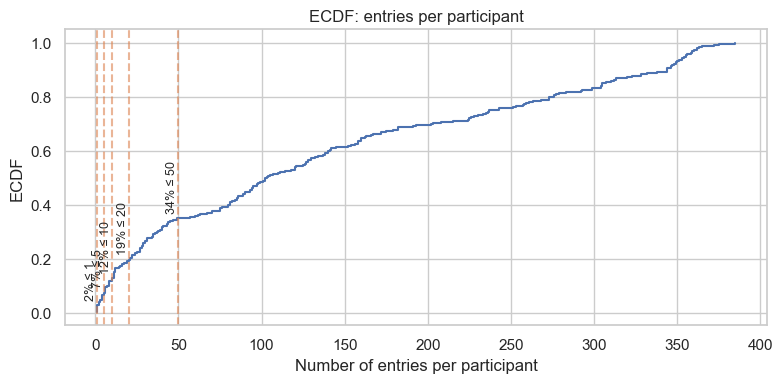

Counts of participants meeting 'at least' thresholds (overall):
  >=  1 entries: 243 participants (100.0%)
  >=  5 entries: 227 participants (93.4%)
  >= 10 entries: 214 participants (88.1%)
  >= 20 entries: 196 participants (80.7%)
  >= 50 entries: 158 participants (65.0%)

Counts of participants with <= threshold, broken down by Group:

<= 1 (n=7):
Group
mLife+Points2       3
mLife (control2)    2
mLife (control)     1
mLife+Points        1
Name: Participant ID, dtype: int64

<= 5 (n=18):
Group
mLife (control2)    7
mLife+Points2       5
mLife (control)     3
mLife+Points        3
Name: Participant ID, dtype: int64

<= 10 (n=31):
Group
mLife (control2)    12
mLife+Points2        8
mLife (control)      6
mLife+Points         5
Name: Participant ID, dtype: int64

<= 20 (n=48):
Group
mLife (control2)    16
mLife+Points2       14
mLife (control)     10
mLife+Points         8
Name: Participant ID, dtype: int64

<= 50 (n=85):
Group
mLife (control2)    28
mLife+Points2       24
mLife (contr

C:\Users\chris\AppData\Local\Temp\ipykernel_42924\2097236779.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ps_df, x='entry_bin', order=labels, palette='muted')


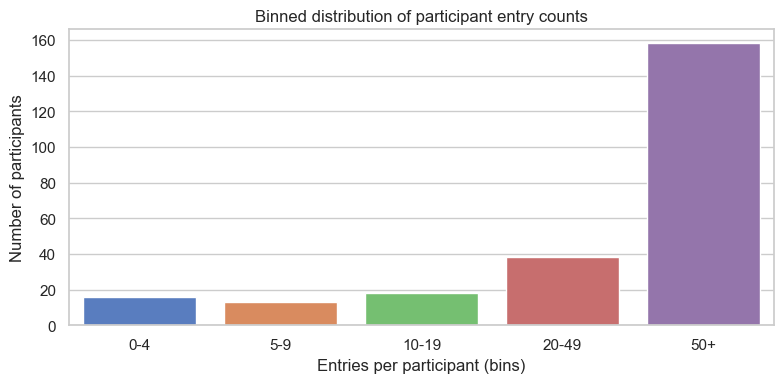


Participants with <= 10 entries: 31 (showing up to 500 rows)


,Participant ID,n_entries,Group
22,31,1,mLife+Points
71,86,1,mLife (control)
117,2012,1,mLife+Points2
161,2061,1,mLife+Points2
204,2119,1,mLife+Points2
232,2155,1,mLife (control2)
168,2075,1,mLife (control2)
153,2051,2,mLife (control2)
82,98,2,mLife (control)
234,2158,2,mLife (control2)


In [ ]:
sns.set(style='whitegrid')

entries_per_participant = df.groupby('Participant ID').size().rename('n_entries')
participant_group = df.groupby('Participant ID')['Group'].agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else x.iloc[0])
ps_df = entries_per_participant.reset_index().merge(participant_group.reset_index(), on='Participant ID', how='left')
ps_df.columns = ['Participant ID','n_entries','Group']

vals = np.sort(ps_df['n_entries'].values)
y = np.arange(1, len(vals)+1) / len(vals)
plt.figure(figsize=(8,4))
plt.step(vals, y, where='post')
plt.xlabel('Number of entries per participant')
plt.ylabel('ECDF')
plt.title('ECDF: entries per participant')
threshs = [1,5,10,20,50]
for t in threshs:
    prop = (ps_df['n_entries'] <= t).mean()
    plt.axvline(t, color='C1', linestyle='--', alpha=0.6)
    plt.text(t, 0.02 + prop, f'{int(100*prop)}% ≤ {t}', rotation=90, va='bottom', ha='right', fontsize=9)
plt.tight_layout()
plt.show()

print("Counts of participants meeting 'at least' thresholds (overall):")
for t in threshs:
    keep = (ps_df['n_entries'] >= t).sum()
    print(f"  >= {t:2d} entries: {keep:3d} participants ({100*keep/len(ps_df):.1f}%)")
print("\nCounts of participants with <= threshold, broken down by Group:")
for t in threshs:
    low = ps_df[ps_df['n_entries'] <= t]
    if low.empty:
        print(f"\n<= {t}: none")
        continue
    print(f"\n<= {t} (n={len(low)}):")
    print(low.groupby('Group')['Participant ID'].count().sort_values(ascending=False))

bins = [0,4,9,19,49,99999]
labels = ['0-4','5-9','10-19','20-49','50+']
ps_df['entry_bin'] = pd.cut(ps_df['n_entries'], bins=bins, labels=labels, right=True)
plt.figure(figsize=(8,4))
sns.countplot(data=ps_df, x='entry_bin', order=labels, palette='muted')
plt.xlabel('Entries per participant (bins)')
plt.ylabel('Number of participants')
plt.title('Binned distribution of participant entry counts')
plt.tight_layout()
plt.show()

CHOSEN_THRESHOLD = 10   # change this to inspect other cutoffs
low_df = ps_df[ps_df['n_entries'] <= CHOSEN_THRESHOLD].sort_values('n_entries')
print(f"\nParticipants with <= {CHOSEN_THRESHOLD} entries: {len(low_df)} (showing up to 500 rows)")
display_cols = ['Participant ID','n_entries','Group']
from IPython.display import display
display(low_df[display_cols].head(500))

